# 1. Handling imports

In [ ]:
import sys
import os

# Add 'predrnn' to sys.path so imports like 'from core...' work
project_root = os.path.abspath("predrnn")  # or use full path if needed
if project_root not in sys.path:
    sys.path.insert(0, project_root)



# PyTorch (related) imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else "cpu")
device = 'cpu'
print("Torch device:", device) # Quick check to see if we're using GPU or CPU.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from pathlib import Path
from IPython.display import clear_output

# Custom imports
import dataset.download_and_preprocess as dl
from dataset.dataloader import KTHDataset
from autoencoder.autoencoder import AutoencoderModel, architectures

# predrnn imports
from predrnn.core.models.predrnn_v2 import RNN as PredRNN
from predrnn.configparser import build_predrnn_args
from predrnn.core.data_provider import datasets_factory

# for reproducibility
np.random.seed(42)


Torch device: cpu


# 2. handling file paths

In [3]:
autoencoder_root_path = Path("autoencoder") / "models"
predrnn_root_path = Path("predrnn") / "checkpoints"
predrnn_base_data_dir = Path("dataset")

# 3. Loading the trained models
## A. Autoencoders

In [ ]:
def load_autoencoder(latent_dimension: int, source_dir: Path) -> AutoencoderModel:
    """Fetches the trained autoencoder with given latent dimension.

    Args:
        latent_dimension (int): The latent dimension the encoder reduces the inputs into
        source_dir (Path): A Path to the directory in which the autoencoders are saved
        
    Returns:
        AutoencoderModel: The loaded autoencoder

    """
    architecture_mapping = {
        64: 1,
        32: 2,
        16: 3
    }
    architecture = architectures[architecture_mapping[latent_dimension]]
    
    best_trial = {
        64: "model_trial_2_1.pt",
        32: "model_trial_1_2.pt",
        16: "model_trial_0_3.pt"
    }
    
    autoencoder =  AutoencoderModel(epochs=200, encoder=architecture["encoder"], decoder=architecture["decoder"]).to(device)
    autoencoder.load(source_dir / best_trial[latent_dimension], device=device)
    autoencoder.eval()
    
    return autoencoder

# autencoder_64 = load_autoencoder(64, autoencoder_root_path) # 64x64 autencoder
# autencoder_32 = load_autoencoder(32, autoencoder_root_path) # 32x32 autencoder
# autencoder_16 = load_autoencoder(16, autoencoder_root_path) # 16x16 autencoder


## B. PredRNN

In [9]:
from predrnn.core.models.model_factory import Model as PredRNNModel

def load_predRNN(latent_dimension: int, predrnn_dir: Path, data_dir: Path) -> PredRNN:
    """Loads a trained PredRNN network.

    Args:
        latent_dimension (int): When given, the network that takes in the provided latent_dimension will be loaded. 
        None results in the vanilla network without autoencoder preprocessing.
        predrnn_dir (Path): Path to the base directory in which the different PredRNN models are stored.
        data_dir (Path): Path to the base directory in which the different datasets are stored.
        

    Returns:
        PredRNN: The loaded network.
        
    """
    # Load vanilla model if no latent dimension is given
    if latent_dimension is None:
        # Hard coded Vanilla configs
        configs = build_predrnn_args(img_width=128, 
                                    data_dir=str((data_dir / 'kth').resolve()), 
                                    result_checkpoint_dir='kth_predrnn_vanilla')
        predRNN = PredRNNModel(configs)
        predRNN.load(str((predrnn_dir / "kth_predrnn_vanilla" / "model.ckpt-400").resolve()))
        
    else:
        # Dynamic loading of latent model based on latent dimension
        configs = build_predrnn_args(img_width=latent_dimension, 
                                    data_dir=str((data_dir / 'encoded' / str(latent_dimension)).resolve()), 
                                    result_checkpoint_dir=f'kth_predrnn_{latent_dimension}')
        predRNN = PredRNNModel(configs)
        predRNN.load(str((predrnn_dir / f"kth_predrnn_{latent_dimension}" / "model.ckpt-400").resolve()))
        
    return predRNN

# predrnn_native = load_predRNN(None, predrnn_root_path, predrnn_base_data_dir) # 128x128 (native) predRNN model
# predrnn_64 = load_predRNN(64, predrnn_root_path, predrnn_base_data_dir)       # 64x64 PredRNN
# predrnn_32 = load_predRNN(32, predrnn_root_path, predrnn_base_data_dir)       # 32x32 PredRNN
# predrnn_16 = load_predRNN(16, predrnn_root_path, predrnn_base_data_dir)       # 16x16 PredRNN


## 4. Load test dataset

In [ ]:
def load_test_dataset(latent_dimension: int, data_dir: Path) -> DataHan:
    """_summary_

    Args:
        latent_dimension (int): The size of the latent dimension of the associated autoencoder. The images are of size (latent_dimension, latent_dimension).
        None indicated no autoencoder is used and the images are the standard (128,128).
        data_dir (Path): A Path to the directory in which the datasets are stored.

    Returns:
        InputHandle: The InputHandle (see data_provider package) with the test data.
    """
    if latent_dimension is None:
        dataset_name = 'action'
        data_path = str((data_dir / 'kth').resolve())
        img_width = 128
    else:
        dataset_name = 'latent'
        data_path = str((data_dir / 'encoded' / str(latent_dimension)).resolve())
        img_width = latent_dimension
        
    test_input_handle = datasets_factory.data_provider(
            dataset_name=dataset_name, 
            train_data_paths=data_path, 
            valid_data_paths=data_path, 
            batch_size=4, 
            img_width=img_width,
            seq_length=20, 
            injection_action='concat', 
            is_training=False)
    return test_input_handle

# test_data_16 = load_test_dataset(16, predrnn_base_data_dir)

## 5. Perform forward pass

In [78]:
latent_size = 64

autoencoder = load_autoencoder(latent_size, autoencoder_root_path)
predrnn = load_predRNN(latent_size, predrnn_root_path, predrnn_base_data_dir)
test_handle = load_test_dataset(None, predrnn_base_data_dir)

load model: /Users/maxneerken/Documents/aml/predrnn-pytorch-AML/predrnn/checkpoints/kth_predrnn_64/model.ckpt-400
begin load data/Users/maxneerken/Documents/aml/predrnn-pytorch-AML/dataset/kth
Preparing to load 13094 video frames.
there are 13094 pictures
there are 4147 sequences


In [79]:
# Training Params #
img_width = latent_size
img_channel = 1
patch_size = 4
batch_size = 4
total_length = 20
input_length = 10
# # # # # # # # # #

In [ ]:
import datetime

from predrnn.core.utils import preprocess

# Reverse schedule sampling #
mask_input = 1

real_input_flag = np.zeros(
    (batch_size,
        total_length - mask_input - 1,
        img_width // patch_size,
        img_width // patch_size,
        patch_size ** 2 * img_channel))

real_input_flag[:, :input_length - 1, :, :] = 1.0
# # # # # # # # # # # # # # #


# # # # #

batch_id = 1
test_ims = test_handle.get_batch()

test_dat = preprocess.reshape_patch(test_ims, patch_size)
test_ims = test_ims[:, :, :, :, :img_channel]

img_gen = predrnn.test(test_dat, real_input_flag)

img_gen = preprocess.reshape_patch_back(img_gen, patch_size)

output_length = total_length - input_length 
img_out = img_gen[:, -output_length:]

img_out.shape

RuntimeError: The size of tensor a (16) must match the size of tensor b (32) at non-singleton dimension 3

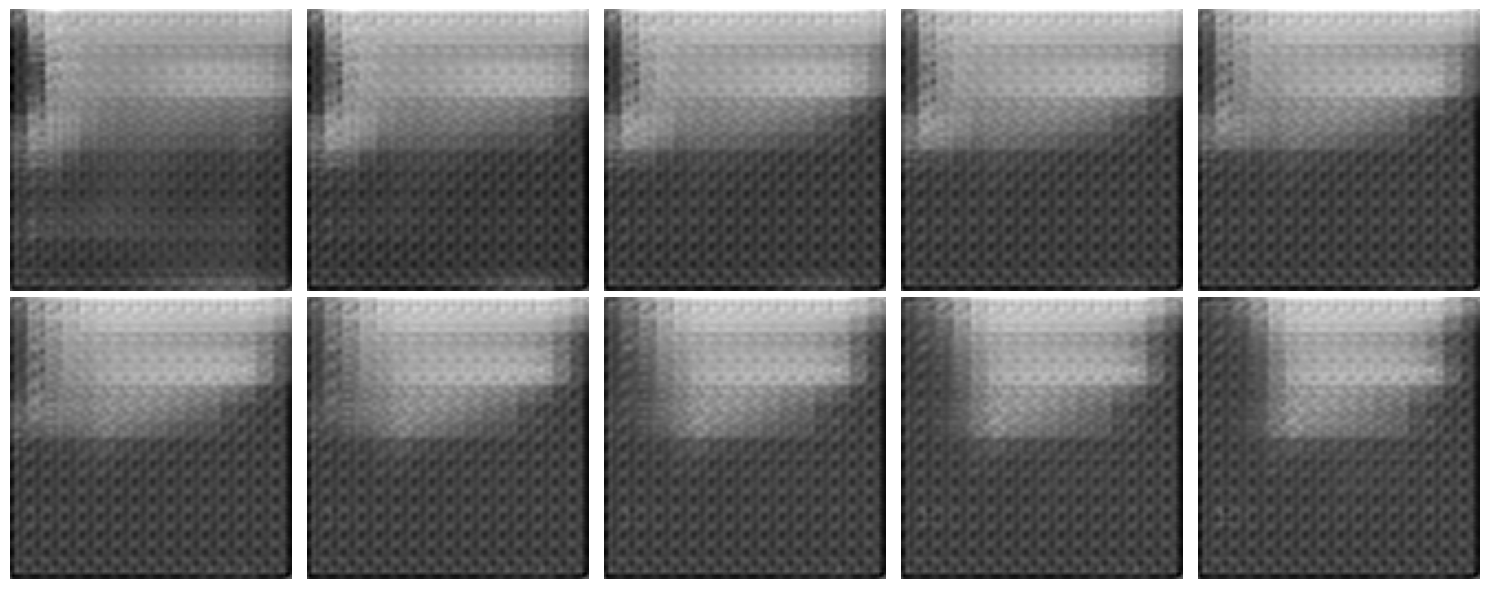

In [40]:
batch_1 = img_out[0]
output_tensor = torch.from_numpy(batch_1)
reshaped_tensor = output_tensor.reshape(10, 1, latent_size, latent_size)
decoded = autoencoder.decode(reshaped_tensor)

numpyy = decoded.detach().numpy()

# Assuming decoded_np is your numpy array with shape (10, 1, 128, 128)
# For demonstration, let's create a random array

# Set up the figure and axes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each image and plot it
for i in range(10):
    # Squeeze the image to remove the channel dimension
    img = numpyy[i].squeeze()  # Shape will be (128, 128)
    axes[i].imshow(img, cmap='gray')  # Display the image in grayscale
    axes[i].axis('off')  # Hide the axes

# Adjust layout
plt.tight_layout()
plt.show()


## 6. Compute metrics

In [ ]:
import lpips

from predrnn.core.utils import metrics
from skimage.metrics import structural_similarity as compare_ssim


def test(predRNN: PredRNNModel, autoencoder: AutoencoderModel):
    
    loss_fn_alex = lpips.LPIPS(net='vgg')
    
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), 'test...')
    test_handle.begin(do_shuffle=False)

    avg_mse = 0
    batch_id = 0
    img_mse, ssim, psnr = [], [], []
    lp = []

    for i in range(total_length - input_length):
        img_mse.append(0)
        ssim.append(0)
        psnr.append(0)
        lp.append(0)

    # Reverse schedule sampling #
    mask_input = 1

    real_input_flag = np.zeros(
        (batch_size,
            total_length - mask_input - 1,
            img_width // patch_size,
            img_width // patch_size,
            patch_size ** 2 * img_channel))

    real_input_flag[:, :input_length - 1, :, :] = 1.0
    # # # # # # # # # # # # # # #

    while (test_handle.no_batch_left() == False):
        batch_id = batch_id + 1
        
        # Retrieve data
        test_ims = test_handle.get_batch()
        
        input = test_ims
        if autoencoder is not None:
            # Encode #
            reshaped_test_ims = test_ims.reshape(batch_size, total_length, 1, 128, 128)
            reshaped_test_ims = torch.from_numpy(reshaped_test_ims)

            encoded_test_ims = torch.stack(list(autoencoder.encode(sequence) for sequence in reshaped_test_ims))
            encoded_test_ims = encoded_test_ims.detach().numpy().reshape(batch_size, total_length, latent_size, latent_size, 1)
            input = encoded_test_ims
            # # # # #
        
        # Patch
        test_dat = preprocess.reshape_patch(input, patch_size)
        test_ims = test_ims[:, :, :, :, :img_channel]
        
        # Forwards
        img_gen = predRNN.test(test_dat, real_input_flag)
        
        # De-patch
        img_gen = preprocess.reshape_patch_back(img_gen, patch_size)
        
        output = img_gen
        if autoencoder is not None:
            # Decode #
            img_gen_reshaped = img_gen.reshape(batch_size, total_length-1, 1, latent_size, latent_size)
            img_gen_reshaped = torch.from_numpy(img_gen_reshaped)

            decoded_img_gen = torch.stack(list(autoencoder.decode(sequence) for sequence in img_gen_reshaped))
            decoded_img_gen = decoded_img_gen.detach().numpy().reshape(batch_size, total_length-1, 128, 128, 1)
            output = decoded_img_gen
            # # # # #

        output_length = total_length - input_length 
        img_out = output[:, -output_length:]

        # Compute metrics per frame
        for i in range(output_length):
            x = test_ims[:, i + input_length, :, :, :]
            gx = img_out[:, i, :, :, :]
            gx = np.maximum(gx, 0)
            gx = np.minimum(gx, 1)
            
            # MSE per frame
            mse = np.square(x - gx).sum()
            img_mse[i] += mse
            avg_mse += mse
            
            # cal lpips
            img_x = np.zeros([batch_size, 3, 128, 128])
            img_x[:, 0, :, :] = x[:, :, :, 0]
            img_x[:, 1, :, :] = x[:, :, :, 0]
            img_x[:, 2, :, :] = x[:, :, :, 0]
            img_x = torch.FloatTensor(img_x)
            
            img_gx = np.zeros([batch_size, 3, 128, 128])
            img_gx[:, 0, :, :] = gx[:, :, :, 0]
            img_gx[:, 1, :, :] = gx[:, :, :, 0]
            img_gx[:, 2, :, :] = gx[:, :, :, 0]
            img_gx = torch.FloatTensor(img_gx)
            lp_loss = loss_fn_alex(img_x, img_gx)
            lp[i] += torch.mean(lp_loss).item()

            real_frm = np.uint8(x * 255)
            pred_frm = np.uint8(gx * 255)

            psnr[i] += metrics.batch_psnr(pred_frm, real_frm)
            
            for b in range(batch_size):
                score, _ = compare_ssim(pred_frm[b], real_frm[b], full=True, channel_axis=2)
                ssim[i] += score

        test_handle.next()
        
        break
    
    return mse, lp, psnr, ssim
    

    avg_mse = avg_mse / (batch_id * batch_size)
    print('mse per seq: ' + str(avg_mse))
    for i in range(total_length - input_length):
        print(img_mse[i] / (batch_id * batch_size))

    ssim = np.asarray(ssim, dtype=np.float32) / (batch_size * batch_id)
    print('ssim per frame: ' + str(np.mean(ssim)))
    for i in range(total_length - input_length):
        print(ssim[i])

    psnr = np.asarray(psnr, dtype=np.float32) / batch_id
    print('psnr per frame: ' + str(np.mean(psnr)))
    for i in range(total_length - input_length):
        print(psnr[i])

    lp = np.asarray(lp, dtype=np.float32) / batch_id
    print('lpips per frame: ' + str(np.mean(lp)))
    for i in range(configs.total_length - configs.input_length):
        print(lp[i])
        
mse, lp, psnr, ssim = test(predrnn, autoencoder)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/maxneerken/miniconda3/envs/aml/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxneerken/miniconda3/envs/aml/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/maxneerken/miniconda3/envs/aml/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
2025-06-30 17:17:20 test...


In [106]:
ssim

[np.float64(2.646048715194071),
 np.float64(2.6115807765622128),
 np.float64(2.6132626499815688),
 np.float64(2.6267781888294737),
 np.float64(2.6372593861654705),
 np.float64(2.651098059735197),
 np.float64(2.657325783031794),
 np.float64(2.66004735624161),
 np.float64(2.6633362955298208),
 np.float64(2.6636151047757153)]

## 7. Plot metrics